In [1]:
from foundational_ssm.dataset import TorchBrainDataset
from torch.utils.data import DataLoader
from foundational_ssm.constants import DATA_ROOT
from omegaconf import OmegaConf
from foundational_ssm.loaders import transform_brainsets_regular_time_series_smoothed

In [2]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
import numpy as np
from tqdm import tqdm

output_notebook()
def plot_intervals(*interval, x_range=None, title=None, width=800, height=200):
    colors = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "black"]
    # Create a figure
    if x_range is None:
      p = figure(title=title, x_axis_label='Time', y_axis_label='Intervals', y_range=(-len(interval), 1), width=width, height=height, x_axis_type="datetime",)
    else:
      p = figure(title=title, x_axis_label='Time', x_range=x_range, y_axis_label='Intervals', y_range=(-len(interval), 1), width=width, height=height, x_axis_type="datetime",)

    p.yaxis.visible = False
    for i in range(len(interval)):
        # Prepare data for plotting
        centers = (interval[i].start + interval[i].end) / 2.  * 1e3
        durations = (interval[i].end - interval[i].start)  * 1e3
        y_values = np.zeros_like(centers) - i  # y-values for the intervals

        # Create a ColumnDataSource
        source = ColumnDataSource(data=dict(x=centers, width=durations, y=y_values))

        # Add rectangles to the plot
        p.rect(x='x', y='y', width='width', height=0.8, source=source, fill_color=colors[i % 10], line_color="black", alpha=0.5)

    return p

Loading BokehJS ...

In [3]:
config_path = "/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/configs/dataset/reaching.yaml"
cfg = OmegaConf.load(config_path) 

all_dataset = TorchBrainDataset(
        root="../"+DATA_ROOT,                # root directory where .h5 files are found
        # recording_id=recording_id,  # you either specify a single recording ID
        config=cfg,                 # or a config for multi-session training / more complex configs
        keep_files_open=True,
        lazy=True,
    )

train_dataset = TorchBrainDataset(
        root="../"+DATA_ROOT,                # root directory where .h5 files are found
        # recording_id=recording_id,  # you either specify a single recording ID
        config=cfg,                 # or a config for multi-session training / more complex configs
        keep_files_open=True,
        lazy=True,
        split="train"
    )
val_dataset = TorchBrainDataset(
        root="../"+DATA_ROOT,                # root directory where .h5 files are found
        # recording_id=recording_id,  # you either specify a single recording ID
        config=cfg,                 # or a config for multi-session training / more complex configs
        keep_files_open=True,
        lazy=True,
        split="val_trial"
    )
test_dataset = TorchBrainDataset(
    root="../"+DATA_ROOT,                # root directory where .h5 files are found
    # recording_id=recording_id,  # you either specify a single recording ID
    config=cfg,                 # or a config for multi-session training / more complex configs
    keep_files_open=True,
    lazy=True,
    split="test_trial"
)
# valid_trials_dataset = TorchBrainDataset(
#     root="../"+DATA_ROOT,                # root directory where .h5 files are found
#     # recording_id=recording_id,  # you either specify a single recording ID
#     config=cfg,                 # or a config for multi-session training / more complex configs
#     keep_files_open=True,
#     lazy=True,
#     split="valid_trials"
# )

all_sampling_intervals = all_dataset.get_sampling_intervals()
train_sampling_intervals = train_dataset.get_sampling_intervals()
val_sampling_intervals = val_dataset.get_sampling_intervals()
test_sampling_intervals = test_dataset.get_sampling_intervals()
# valid_trials_sampling_intervals = valid_trials_dataset.get_sampling_intervals()
        

In [6]:
from temporaldata import Interval
activation_recording_ids = [
    'perich_miller_population_2018/c_20161011_center_out_reaching',
    'perich_miller_population_2018/c_20131212_random_target_reaching',
    'perich_miller_population_2018/m_20140203_center_out_reaching',
    'perich_miller_population_2018/m_20140114_random_target_reaching',
    'pei_pandarinath_nlb_2021/jenkins_maze',
    'odoherty_sabes_nonhuman_2017/indy_20170131_02',
    'churchland_shenoy_neural_2012/jenkins_20090923_center_out_reaching'
    ]

for i, (recording_id, train_intervals) in tqdm(enumerate(train_sampling_intervals.items())):
    if recording_id in activation_recording_ids:
    # if i % 10 == 0:
        all_intervals = all_sampling_intervals[recording_id]
        val_intervals = val_sampling_intervals[recording_id]
        test_intervals = test_sampling_intervals[recording_id]
        outlier_segments = getattr(all_dataset.get_recording_data(recording_id), "cursor_outlier_segments", Interval(0,0))
        # valid_trials_intervals = valid_trials_sampling_intervals[recording_id]
        if hasattr(all_dataset.get_recording_data(recording_id), "movement_phases"):
            hold_segments = getattr(all_dataset.get_recording_data(recording_id).movement_phases, "hold_period", Interval(0,0))
            return_segments = getattr(all_dataset.get_recording_data(recording_id).movement_phases, "return_period", Interval(0,0))
            fig = plot_intervals(all_intervals, outlier_segments, train_intervals, val_intervals, test_intervals, hold_segments, return_segments, title=recording_id)
        else:
            fig = plot_intervals(all_intervals, train_intervals, val_intervals, test_intervals, title=recording_id)
        # print(len(valid_trials_intervals.start))
        show(fig)

0it [00:00, ?it/s]

15it [00:00, 91.10it/s]

66it [00:00, 214.75it/s]

88it [00:00, 113.96it/s]

130it [00:00, 156.99it/s]

147it [00:01, 116.56it/s]


In [8]:
from temporaldata import Interval
activation_recording_ids = [
    'perich_miller_population_2018/c_20161011_center_out_reaching'
    ]

start = 500
duration = 50
end = start+ duration

for i, (recording_id, train_intervals) in tqdm(enumerate(train_sampling_intervals.items())):
    if recording_id in activation_recording_ids:
    # if i % 10 == 0:
        all_intervals = all_sampling_intervals[recording_id] & Interval(start, end)
        val_intervals = val_sampling_intervals[recording_id] & Interval(start, end)
        test_intervals = test_sampling_intervals[recording_id] & Interval(start, end)
        outlier_segments = getattr(all_dataset.get_recording_data(recording_id), "cursor_outlier_segments", Interval(0,0)) & Interval(start, end)
        # valid_trials_intervals = valid_trials_sampling_intervals[recording_id]
        if hasattr(all_dataset.get_recording_data(recording_id), "movement_phases"):
            reach_segments = getattr(all_dataset.get_recording_data(recording_id).movement_phases, "reach_period", Interval(0,0)) & Interval(start, end)
            reach_segments = getattr(all_dataset.get_recording_data(recording_id).movement_phases, "reach_period", Interval(0,0)) & Interval(start, end)
            hold_segments = getattr(all_dataset.get_recording_data(recording_id).movement_phases, "hold_period", Interval(0,0)) & Interval(start, end)
            return_segments = getattr(all_dataset.get_recording_data(recording_id).movement_phases, "return_period", Interval(0,0)) & Interval(start, end)
            fig = plot_intervals(all_intervals, outlier_segments, train_intervals & Interval(start,end), val_intervals, test_intervals, reach_segments, hold_segments, return_segments, title=recording_id)
        else:
            fig = plot_intervals(all_intervals, train_intervals, val_intervals, test_intervals, title=recording_id)
        # print(len(valid_trials_intervals.start))
        show(fig)
        break

0it [00:00, ?it/s]

65it [00:00, 277.12it/s]


In [30]:
all_dataset.get_recording_data(recording_id).movement_phases

Data(
hold_period=LazyInterval(
  end=<HDF5 dataset "end": shape (3004,), type "<f8">,
  start=<HDF5 dataset "start": shape (3004,), type "<f8">
),
reach_period=LazyInterval(
  end=<HDF5 dataset "end": shape (3005,), type "<f8">,
  start=<HDF5 dataset "start": shape (3005,), type "<f8">
),
return_period=LazyInterval(
  end=<HDF5 dataset "end": shape (3004,), type "<f8">,
  start=<HDF5 dataset "start": shape (3004,), type "<f8">
),
_absolute_start=0.0,
)

In [16]:
from foundational_ssm.dataset import DatasetIndex
from foundational_ssm.collate import pad_collate
from foundational_ssm.transform import transform_brainsets_regular_time_series_smoothed
valid_trials_dataset.transform = transform_brainsets_regular_time_series_smoothed
session_id = 'odoherty_sabes_nonhuman_2017/indy_20170131_02'
batch = []
for trial_interval in valid_trials_sampling_intervals[session_id]:
    trial_idx = DatasetIndex(session_id, trial_interval[0], trial_interval[1])
    sample = valid_trials_dataset[trial_idx]
    batch.append(sample)

batch = pad_collate(batch)

np.save('indy_20170131_02_neural_input.npy',batch['neural_input'])

# Get info of all recordings, by subject and task.

In [ ]:
import numpy as np
from typing import Dict, Tuple, Any
from tqdm import tqdm
import re

def parse_session_id(session_id: str) -> Tuple[str, str, str]:
    patterns = {
        "churchland_shenoy_neural_2012": re.compile(r"([^/]+)/([^_]+)_[0-9]+_(.+)"),
        "flint_slutzky_accurate_2012": re.compile(r"([^/]+)/monkey_([^_]+)_e1_(.+)"),
        "odoherty_sabes_nonhuman_2017": re.compile(r"([^/]+)/([^_]+)_[0-9]{8}_[0-9]+"),
        "pei_pandarinath_nlb_2021": re.compile(r"([^/]+)/([^_]+)_(.+)"),
        "perich_miller_population_2018": re.compile(r"([^/]+)/([^_]+)_[0-9]+_(.+)"),
    }

    dataset = session_id.split('/')[0]
    if dataset not in patterns:
        raise ValueError(f"Unknown dataset: {dataset}")

    match = patterns[dataset].match(session_id)
    if not match:
        raise ValueError(f"Could not parse session_id: {session_id!r}")

    if dataset == "odoherty_sabes_nonhuman_2017":
        # Always assign task as 'random_target_reaching'
        _, subject = match.groups()
        return dataset, subject, "random_target_reaching"
    elif dataset == "flint_slutzky_accurate_2012":
        # task is always 'center_out_reaching'
        _, subject, _ = match.groups()
        return dataset, subject, "center_out_reaching"
    else:
        return match.groups()


DATASET_GROUP_INFO: Dict[Tuple[str, str, str], Dict[str, Any]] = {}

for i, (recording_id, train_intervals) in tqdm(enumerate(train_sampling_intervals.items())):
    recording_data = train_dataset.get_recording_data(recording_id)
    num_units = int(np.max(recording_data.spikes.unit_index))
    dataset, subject, task = parse_session_id(recording_id)
    train_duration = np.sum(train_intervals.end - train_intervals.start)
    # print(type(recording_data.cursor.vel))
    if recording_id.startswith("pei_pandarinath_nlb_2021"):
        behavior_sampling_rate = np.min(recording_data.hand.timestamps[1:] - recording_data.hand.timestamps[:-1])
    else:    
        behavior_sampling_rate = np.min(recording_data.cursor.timestamps[1:] - recording_data.cursor.timestamps[:-1])
    if (dataset, subject, task) not in DATASET_GROUP_INFO:
        DATASET_GROUP_INFO[(dataset, subject, task)] = {
            "max_num_units": num_units,
            "behavior_dim": 2,
            "train_duration": float(round(train_duration, 2)),
            "min_behavior_sampling_rate": behavior_sampling_rate,
        }
    else:
        DATASET_GROUP_INFO[(dataset, subject, task)]["max_num_units"] = max(DATASET_GROUP_INFO[(dataset, subject, task)]["max_num_units"], num_units)
        DATASET_GROUP_INFO[(dataset, subject, task)]["train_duration"] = DATASET_GROUP_INFO[(dataset, subject, task)]["train_duration"] + train_duration
        DATASET_GROUP_INFO[(dataset, subject, task)]["min_behavior_sampling_rate"] = min(DATASET_GROUP_INFO[(dataset, subject, task)]["min_behavior_sampling_rate"], behavior_sampling_rate)

0it [00:00, ?it/s]

154it [08:34,  3.34s/it]


# Test that IrregularTimeSeries's new to_regular function works

/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


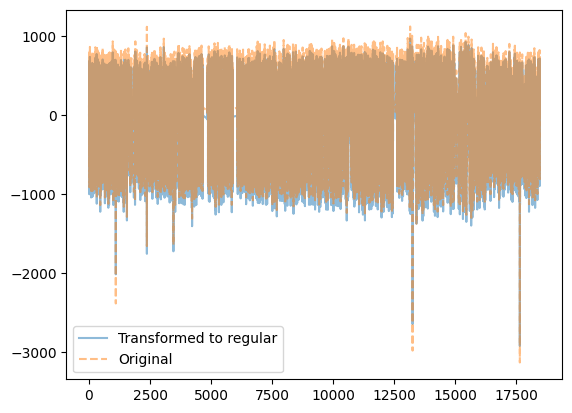

In [39]:
import matplotlib.pyplot as plt


recording_id = "churchland_shenoy_neural_2012/nitschke_20090819_center_out_reaching"
recording_data = train_dataset.get_recording_data(recording_id)
sliced_recording_data = recording_data#.slice(900, 901)
regular_hand, regular_times = sliced_recording_data.cursor.get_regular_time_series_array(200, "vel")
# regular_times = sliced_recording_data.cursor.get_regular_time_series_array(100, "timestamps")

plt.plot(regular_times, regular_hand[:, 0], label="Transformed to regular", alpha=0.5)
# With offset to see the difference
plt.plot(sliced_recording_data.cursor.timestamps, sliced_recording_data.cursor.vel[:, 0] + 100, label="Original", alpha=0.5, linestyle="--")

plt.legend()

In [41]:
recording_data.domain.start

array([2.71966667e+00, 9.81976667e+00, 1.48798000e+01, ...,
       1.84512452e+04, 1.84553801e+04, 1.84604302e+04], shape=(3126,))

In [40]:
regular_times

array([2.71966667e+00, 2.72466667e+00, 2.72966667e+00, ...,
       1.84629297e+04, 1.84629347e+04, 1.84629397e+04], shape=(3692045,))

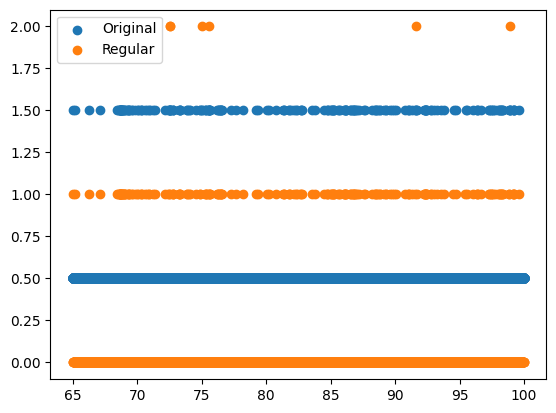

In [42]:
regular_spikes = sliced_recording_data.spikes.get_regular_time_series_array(100, "unit_index", is_index=True)
# Test that the regular spikes is the same as the original spikes
unit_to_plot = 0
irregular_spikes = sliced_recording_data.spikes.unit_index == unit_to_plot
irregular_spikes_times = sliced_recording_data.spikes.timestamps[irregular_spikes]
plt.scatter(sliced_recording_data.spikes.timestamps, irregular_spikes+0.5, label="Original")
plt.scatter(regular_times, regular_spikes[:,unit_to_plot], label="Regular")
plt.legend()
plt.show()

# Test that the regular spikes is the same as the original spikes

In [ ]:
from foundational_ssm.data_utils.samplers import RandomFixedWindowSampler 
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from typing import Dict, Any
from foundational_ssm.data_utils.spikes import smooth_spikes
from foundational_ssm.constants import DATASET_GROUP_TO_IDX, MAX_NEURAL_UNITS, MAX_BEHAVIOR_DIM, parse_session_id
from foundational_ssm.data_utils.loaders import _ensure_dim
from temporaldata import Interval
import logging
logging.getLogger().setLevel(logging.ERROR)
# from foundational_ssm.data_utils.loaders import transform_brainsets_regular_time_series_smoothed

def transform_brainsets_regular_time_series_smoothed(
    data: Any,
    *,
    sampling_rate: int = 100,
    sampling_window_ms: int = 1000,
    kern_sd_ms: int = 20,
) -> Dict[str, torch.Tensor | str]:
    """Convert a *temporaldata* sample to a dictionary of Torch tensors.

    The function takes care of binning & smoothing spikes, cropping/padding neural
    and behavioural features to a globally consistent dimensionality that depends
    on the *(dataset, subject, task)* triple.

    Parameters
    ----------
    data: temporaldata.Data
        Sample returned by **torch-brain**/**temporaldata**.
    sampling_rate: int, default=100
        Target sampling rate *Hz* used for binning.
    sampling_window_ms: int, default=1000   
        Length of the temporal window after binning.
    kern_sd_ms: int, default=20
        Standard deviation of the Gaussian kernel (in ms) for smoothing spikes.

    Returns
    -------
    Dict[str, torch.Tensor]
        Dictionary with keys ``neural_input``, ``behavior_input``, ``session_id``
        and ``subject_id``.
    """

    num_timesteps = int(sampling_rate * sampling_window_ms / 1000)
    bin_size_ms = int(1000 / sampling_rate)
    # ------------------------------------------------------------------
    # 1. Bin + smooth spikes
    # ------------------------------------------------------------------
    binned_spikes, _ = data.spikes.get_regular_time_series_array(
        sampling_rate=sampling_rate,
        raw_array_name="unit_index",
        is_index=True,
    )  # shape: (timesteps, units)

    smoothed_spikes = smooth_spikes(
        binned_spikes,
        kern_sd_ms=kern_sd_ms,
        bin_size_ms=bin_size_ms,
        time_axis=0,
    )

    # ------------------------------------------------------------------
    # 2. Prepare behaviour signal (cursor velocity)
    # ------------------------------------------------------------------
    if data.session.id.startswith("pei_pandarinath_nlb_2021"):
        behavior_input, _ = data.hand.get_regular_time_series_array(
            sampling_rate=sampling_rate,
            raw_array_name="vel",
        )  # np.ndarray, (timesteps, features)
    else:
        behavior_input, _ = data.cursor.get_regular_time_series_array(
            sampling_rate=sampling_rate,
            raw_array_name="vel",
        )  # np.ndarray, (timesteps, features)

    # ------------------------------------------------------------------
    # 3. Align channel dimensions based on (dataset, subject, task)
    # ------------------------------------------------------------------
    dataset, subject, task = parse_session_id(data.session.id)
    group_tuple = (dataset, subject, task)
    group_idx = DATASET_GROUP_TO_IDX[group_tuple]
    smoothed_spikes = _ensure_dim(smoothed_spikes, MAX_NEURAL_UNITS, axis=1)
    behavior_input = _ensure_dim(behavior_input, MAX_BEHAVIOR_DIM, axis=1)

    # ------------------------------------------------------------------
    # 4. Pack into torch tensors
    # ------------------------------------------------------------------
    return {
        "neural_input": torch.as_tensor(smoothed_spikes, dtype=torch.float32),
        "behavior_input": torch.as_tensor(behavior_input, dtype=torch.float32),
        "dataset_group_idx": torch.as_tensor(group_idx, dtype=torch.int32),
    }

cfg = OmegaConf.load("../configs/dataset/possm_pretrain.yaml")
train_dataset = TorchBrainDataset(
        root="../"+DATA_ROOT,                # root directory where .h5 files are found
        # recording_id=recording_id,  # you either specify a single recording ID
        config=cfg,                 # or a config for multi-session training / more complex configs
        keep_files_open=True,
        lazy=True,
        split="train"
    )

train_sampling_intervals = train_dataset.get_sampling_intervals()

train_sampler = RandomFixedWindowSampler(
    sampling_intervals=train_sampling_intervals,
    window_length=1.0
)


train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=1024, num_workers=8)
train_dataset.transform = transform_brainsets_regular_time_series_smoothed
batches = []



In [8]:
for batch in tqdm(train_loader):
    batches.append(batch)

  0%|          | 0/197 [00:00<?, ?it/s]/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
 

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ~~~~~~~~~~~~~~~^^^^^^
  File "/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py", line 172, in collate
    key: collate(
         ~~~~~~~^
        [d[key] for d in batch], collate_fn_map=collate_fn_map
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py", line 271, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


1001it [01:31, 10.99it/s]


Text(0.5, 1.0, 'Time to transform data')

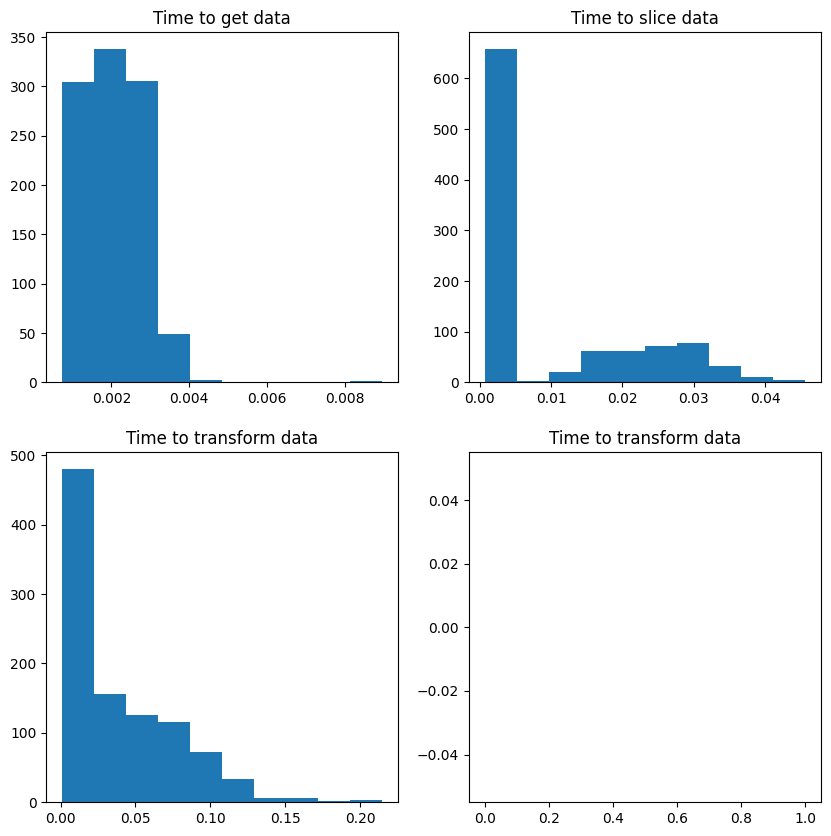

In [17]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

sample_index_info = []
for i, sample_index in tqdm(enumerate(train_sampler)):
    try:
        recording_id = sample_index.recording_id
        t0 = time.time()
        recording_data = train_dataset.get_recording_data(recording_id)
        t1 = time.time()
        sample = recording_data.slice(sample_index.start, sample_index.end)
        t2 = time.time()
        transformed_sample = transform_brainsets_regular_time_series_smoothed(sample)
        t3 = time.time()
        
        sample_index_info.append({
            "recording_id": recording_id,
            "start": sample_index.start,
            "end": sample_index.end,
            "get_recording_data_time": t1 - t0,
            "slice_time": t2 - t1,
            "transform_time": t3 - t2,
            "neural_input_dim_0_shape": transformed_sample["neural_input"].shape[0],
            "neural_input_dim_1_shape": transformed_sample["neural_input"].shape[1],
            "behavior_input_dim_0_shape": transformed_sample["behavior_input"].shape[0],
            "behavior_input_dim_1_shape": transformed_sample["behavior_input"].shape[1],
        })
    except Exception as e:
        sample_index_info.append({
            "recording_id": recording_id,
            "start": sample_index.start,
            "end": sample_index.end,
            "error": str(e),
        })
        continue
    if i > 1000:
        break 



In [18]:
sample_index_info_df = pd.DataFrame(sample_index_info)

In [23]:
sample_index_info_df["dataset"] = sample_index_info_df["recording_id"].apply(lambda x: x.split("/")[0])

<Axes: xlabel='dataset'>

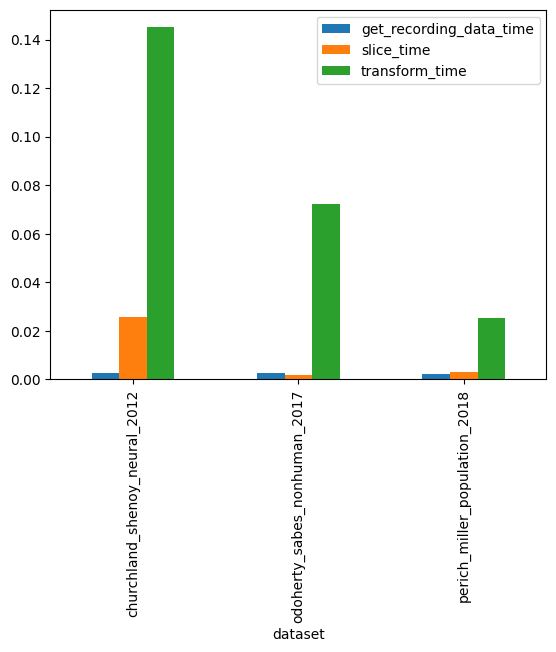

In [24]:
sample_index_info_df.groupby("dataset").agg({"get_recording_data_time": "mean", "slice_time": "mean", "transform_time": "mean"}).plot(kind="bar")

Text(0.5, 1.0, 'behavior_input_dim_1_shape')

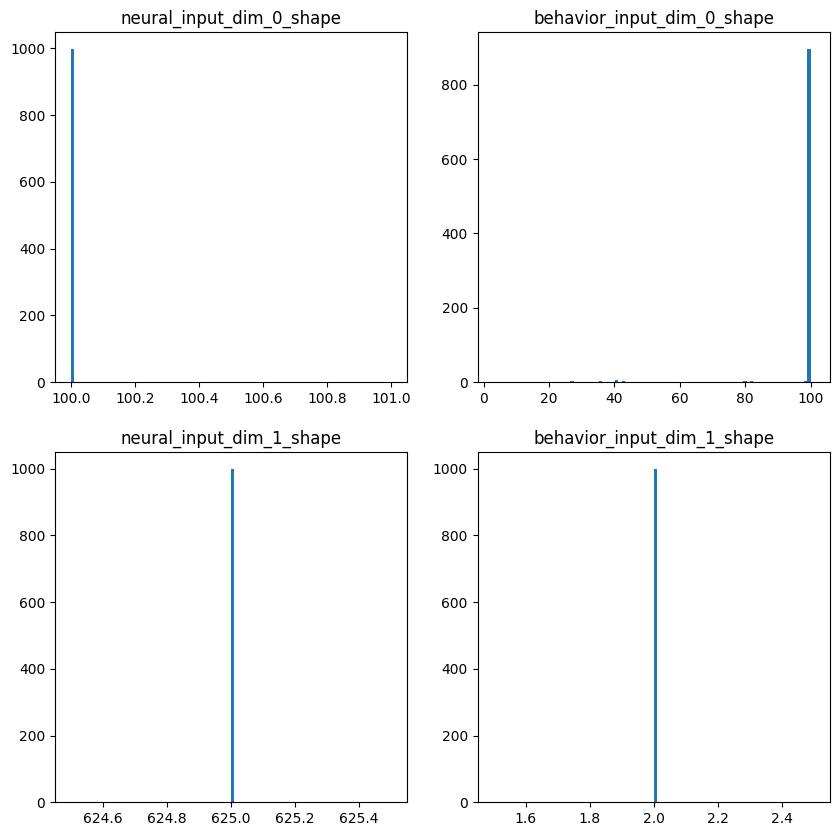

In [15]:
import matplotlib.pyplot as plt

# plot histogram of dimensions of neural_input and behavior_input in subplots   
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(neural_input_dim_0_shape, bins=100)
axs[0, 0].set_title("neural_input_dim_0_shape")
axs[0, 1].hist(behavior_input_dim_0_shape, bins=100)
axs[0, 1].set_title("behavior_input_dim_0_shape")
axs[1, 0].hist(neural_input_dim_1_shape, bins=100)
axs[1, 0].set_title("neural_input_dim_1_shape")
axs[1, 1].hist(behavior_input_dim_1_shape, bins=100)
axs[1, 1].set_title("behavior_input_dim_1_shape")

In [16]:
import numpy as np
print(np.unique(neural_input_dim_0_shape))
print(np.unique(behavior_input_dim_0_shape))
print(np.unique(neural_input_dim_1_shape))
print(np.unique(behavior_input_dim_1_shape))

[100 101]
[  3   6  12  16  18  19  20  21  22  23  25  26  27  29  31  32  34  35
  36  37  39  40  41  43  45  46  47  48  49  50  53  54  55  56  58  61
  62  63  64  65  66  67  70  71  72  74  76  77  79  80  81  82  83  84
  85  86  87  88  89  90  91  95  99 100 101]
[625]
[2]


In [5]:
%load_ext line_profiler
%lprun \
    -f TorchBrainDataset.get_recording_data \
    train_dataset.get_recording_data(sample_index.recording_id)

Timer unit: 1e-09 s

Total time: 0.00534338 s
File: /cs/student/projects1/ml/2024/mlaimon/foundational_ssm/src/foundational_ssm/data_utils/dataset.py
Function: get_recording_data at line 358

Line #      Hits         Time  Per Hit   % Time  Line Contents
   358                                               def get_recording_data(self, recording_id: str):
   359                                                   r"""Returns the data object corresponding to the recording :obj:`recording_id`.
   360                                                   If the split is not :obj:`None`, the data object is sliced to the allowed sampling
   361                                                   intervals for the split, to avoid any data leakage. :obj:`RegularTimeSeries`
   362                                                   objects are converted to :obj:`IrregularTimeSeries` objects, since they are
   363                                                   most likely no longer contiguous.
   364  

In [34]:
# %load_ext line_profiler
%lprun -f transform_brainsets_regular_time_series_smoothed transform_brainsets_regular_time_series_smoothed(sliced_recording_data)

Timer unit: 1e-09 s

Total time: 0.00894234 s
File: /tmp/ipykernel_339862/865079328.py
Function: transform_brainsets_regular_time_series_smoothed at line 14

Line #      Hits         Time  Per Hit   % Time  Line Contents

Timer unit: 1e-09 s

Total time: 0.00162503 s
File: /cs/student/projects1/ml/2024/mlaimon/temporaldata/temporaldata/temporaldata.py
Function: get_regular_time_series_array at line 724

Line #      Hits         Time  Per Hit   % Time  Line Contents
   724                                               def get_regular_time_series_array(self, sampling_rate, raw_array_name, is_index=False):
   725                                                   """
   726                                                   Convert an IrregularTimeSeries attribute to a regular time grid.
   727                                                   
   728                                                   Args:
   729                                                       irregular: IrregularTimeSeries object
   730                                                       sampling_rate: float, Hz
   731                                                       raw_array_name: str, attribute to convert (e.g., 'vel', 'raw'

In [ ]:
for dataset_index in tqdm(train_sampler):
    try:
        slice = train_dataset[dataset_index]
    except Exception as e:
        errors_indices.append(dataset_index)
        sample_interval = Interval(dataset_index.start, dataset_index.end)
        old_interval = old_train_sampling_intervals[dataset_index.recording_id] & Interval(dataset_index.start-5, dataset_index.end+5)
        new_interval = train_sampling_intervals[dataset_index.recording_id] & Interval(dataset_index.start-5, dataset_index.end+5)
        old_all_interval = all_sampling_intervals[dataset_index.recording_id] & Interval(dataset_index.start-5, dataset_index.end+5)
        fig = plot_intervals(sample_interval, old_interval, new_interval, old_all_interval, title=dataset_index.recording_id)
        print(e)
        show(fig)

In [27]:
errors_indices

[DatasetIndex(recording_id='perich_miller_population_2018/m_20150512_center_out_reaching', start=2030.5735375881195, end=2031.5735375881195),
 DatasetIndex(recording_id='perich_miller_population_2018/m_20150512_center_out_reaching', start=2381.5735375881195, end=2382.5735375881195),
 DatasetIndex(recording_id='perich_miller_population_2018/m_20150512_center_out_reaching', start=2446.5735375881195, end=2447.5735375881195),
 DatasetIndex(recording_id='perich_miller_population_2018/m_20150512_center_out_reaching', start=2013.5735375881195, end=2014.5735375881195),
 DatasetIndex(recording_id='perich_miller_population_2018/m_20150512_center_out_reaching', start=2420.5735375881195, end=2421.5735375881195),
 DatasetIndex(recording_id='perich_miller_population_2018/m_20150512_center_out_reaching', start=2270.5735375881195, end=2271.5735375881195),
 DatasetIndex(recording_id='perich_miller_population_2018/m_20150512_center_out_reaching', start=2398.5735375881195, end=2399.5735375881195),
 Datas

In [39]:
old_sampling_interval_errors_indices = []
train_sampler = RandomFixedWindowSampler(
    sampling_intervals=old_all_sampling_intervals,
    window_length=1.0
)

# train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=1)
for dataset_index in tqdm(train_sampler):
    try:
        slice = train_dataset[dataset_index]
    except Exception as e:
        old_sampling_interval_errors_indices.append(dataset_index)
        sample_interval = Interval(dataset_index.start, dataset_index.end)
        # old_interval = old_train_sampling_intervals[dataset_index.recording_id] & Interval(dataset_index.start-5, dataset_index.end+5)
        new_interval = train_sampling_intervals[dataset_index.recording_id] & Interval(dataset_index.start-5, dataset_index.end+5)
        old_used_intervals = (old_valid_sampling_intervals[dataset_index.recording_id] | old_test_sampling_intervals[dataset_index.recording_id] | old_train_sampling_intervals[dataset_index.recording_id]) & Interval(dataset_index.start-5, dataset_index.end+5)
        fig = plot_intervals(sample_interval, old_used_intervals, new_interval, title=dataset_index.recording_id)
        print(e)
        show(fig)

  0%|          | 388/279607 [00:34<7:20:28, 10.57it/s]

zero-size array to reduction operation maximum which has no identity


  0%|          | 437/279607 [00:37<4:50:08, 16.04it/s]

zero-size array to reduction operation maximum which has no identity


  0%|          | 612/279607 [00:49<4:23:32, 17.64it/s]

index 0 is out of bounds for axis 0 with size 0


  0%|          | 845/279607 [01:07<5:03:50, 15.29it/s] 

zero-size array to reduction operation maximum which has no identity


  0%|          | 1061/279607 [01:23<6:58:26, 11.09it/s] 

index 0 is out of bounds for axis 0 with size 0


  0%|          | 1090/279607 [01:25<5:14:06, 14.78it/s] 

zero-size array to reduction operation maximum which has no identity


  0%|          | 1116/279607 [01:28<6:29:15, 11.92it/s] 

zero-size array to reduction operation maximum which has no identity


  0%|          | 1288/279607 [01:39<5:26:14, 14.22it/s] 

index 0 is out of bounds for axis 0 with size 0


  1%|          | 1561/279607 [01:58<5:50:50, 13.21it/s] 


KeyboardInterrupt: 

In [30]:
train_dataset[errors_indices[7]]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [8]:
train_dataset.get_recording_data(dataset_index.recording_id).slice(dataset_index.start-5, dataset_index.end+5)

Data(
brainset=Data(
brainsets_version='0.1.0',
derived_version='1.0.0',
description='This dataset contains electrophysiology and behavioral data from three macaques performing either a center-out task or a continuous random target acquisition task. Neural activity was recorded from chronically-implanted electrode arrays in the primary motor cortex (M1) or dorsal premotor cortex (PMd) of four rhesus macaque monkeys. A subset of sessions includes recordings from both regions simultaneously. The data contains spiking activity—manually spike sorted in three subjects, and threshold crossings in the fourth subject—obtained from up to 192 electrodes per session, cursor position and velocity, and other task related metadata.',
id='perich_miller_population_2018',
origin_version='dandi/000688/draft',
source='https://dandiarchive.org/dandiset/000688',
temporaldata_version='0.1.1',
_absolute_start=0.0,
),
cursor=LazyIrregularTimeSeries(
  timestamps=[1100],
  acc=<HDF5 dataset "acc": shape (63801

In [20]:
smoothed_spikes = train_dataset.get_recording_data("perich_miller_population_2018/m_20150512_center_out_reaching").smoothed_spikes
smoothed_spikes.smoothed_spikes[(smoothed_spikes.timestamps > 2215.436751663685) & (smoothed_spikes.timestamps < 2216.436751663685)]

AttributeError: 'LazyIrregularTimeSeries' object has no attribute 'units'

In [23]:
smoothed_spikes.smoothed_spikes[(smoothed_spikes.timestamps > 2215.436751663685) & (smoothed_spikes.timestamps < 2216.436751663685)].sum()

np.float64(0.0)

In [ ]:
smoothed_spikes.units[(smoothed_spikes.timestamps > 2215.436751663685) & (smoothed_spikes.timestamps < 2216.436751663685)]

In [42]:
behav = train_dataset.get_recording_data("perich_miller_population_2018/m_20150512_center_out_reaching").cursor.vel
timestamps = train_dataset.get_recording_data("perich_miller_population_2018/m_20150512_center_out_reaching").cursor.timestamps
# timestamps[timestamps > 2281.2462391853333]
# timestamps[timestamps > 2282.2462391853333]
timestamps

array([0.00000e+00, 1.00000e-02, 2.00000e-02, ..., 6.38011e+03,
       6.38012e+03, 6.38013e+03], shape=(456727,))

In [16]:
timestamps[(timestamps > 2281.2462391853333) | (timestamps < 2282.2462391853333)]

array([2.56666667e-03, 6.23333333e-03, 1.20000000e-02, ...,
       6.38013757e+03, 6.38013953e+03, 6.38013977e+03], shape=(2164986,))

In [ ]:
session_ids = train_dataset.get_session_ids()
for session_id in session_ids:
    recording_data = train_dataset.get_recording_data(session_id)
    start = recording_data.start
    end = recording_data.end
    train_end = int(0.7 * (end - start)) + start
    val_end = int(0.8 * (end - start)) + start

    sampling_intervals = {
        "train": {"start":start, "end":train_end}, 
        "valid": {"start":train_end, "end":val_end}, 
        "test": {"start":val_end, "end":end}}

    for split in ["train", "valid", "test"]:
        if split == "train":
            sampling_intervals[split]["intervals"] = Interval(start, train_end)
            remainder = recording_data.slice(train_end, end, reset_origin=False) 
        elif split in ["valid", "test"]: 
            full_interval = recording_data.slice(sampling_intervals[split]["start"], sampling_intervals[split]["end"], reset_origin=False)
            if session_id.startswith("odoherty_sabes"):
                window_size = 5.
                starts = list(np.arange(full_interval.domain.start[0], full_interval.domain.end[0], window_size))
                ends = list(np.arange(full_interval.domain.start[0] + window_size, full_interval.domain.end[0], window_size)) + [full_interval.domain.end[0]]
                sampling_intervals[split]["intervals"] = Interval.from_list(list(zip(starts, ends)))

            else:
                sampling_intervals[split]["intervals"] = full_interval.trials

    trial_gaps = remainder.domain.difference(sampling_intervals["valid"]["intervals"] | sampling_intervals["test"]["intervals"])
    sampling_intervals["train"]["intervals"] = sampling_intervals["train"]["intervals"] | trial_gaps

fig = plot_intervals(sampling_intervals["train"]["intervals"], sampling_intervals["valid"]["intervals"], sampling_intervals["test"]["intervals"], title=session_id)
show(fig)

154


In [26]:
sampling_intervals["test"]["end"]

np.float64(3730.584)

In [21]:
recording_data.domain

Interval(
  end=[1],
  start=[1]
)

In [7]:
from torch_brain.data.sampler import TrialSampler

train_sampler = TrialSampler(
    sampling_intervals=sampling_intervals
)

In [ ]:
train_loader = DataLoader(
        dataset=train_dataset,
        sampler=train_sampler,
        # collate_fn=collate_fn,
        num_workers=0,
        pin_memory=True,
    )
train_dataset.transform = gr

In [14]:
sampling_intervals

LazyInterval(
  end=<HDF5 dataset "end": shape (1,), type "<f8">,
  start=<HDF5 dataset "start": shape (1,), type "<f8">
)

In [24]:
train_dataset.get_recording_data("perich_miller_population_2018/c_20131003_center_out_reaching").trials

LazyInterval(
  end=[144],
  go_cue_time=<HDF5 dataset "go_cue_time": shape (193,), type "<f8">,
  is_valid=<HDF5 dataset "is_valid": shape (193,), type "|b1">,
  result=<HDF5 dataset "result": shape (193,), type "|O">,
  start=[144],
  start_time=<HDF5 dataset "start_time": shape (193,), type "<f8">,
  stop_time=<HDF5 dataset "stop_time": shape (193,), type "<f8">,
  target_corners=<HDF5 dataset "target_corners": shape (193, 4), type "<f8">,
  target_dir=<HDF5 dataset "target_dir": shape (193,), type "<f8">,
  target_id=<HDF5 dataset "target_id": shape (193,), type "<f8">,
  target_on_time=<HDF5 dataset "target_on_time": shape (193,), type "<f8">
)

In [21]:
train_dataset.get_recording_data("perich_miller_population_2018/c_20131003_center_out_reaching").trials.start

array([  5.08426667,   8.10176667,  11.26563333,  14.20393333,
        17.83093333,  20.291     ,  21.366     ,  23.06693333,
        27.78066667,  31.63023333,  35.8517    ,  43.02353333,
        46.34276667,  54.78073333,  57.88743333,  64.149     ,
        67.39706667,  76.1478    ,  87.5782    ,  91.00773333,
        94.31393333,  99.899     , 100.959     , 101.623     ,
       102.562     , 103.113     , 108.39993333, 111.50863333,
       114.96923333, 119.11553333, 122.17916667, 128.91386667,
       138.1398    , 142.11066667, 145.0299    , 147.89003333,
       151.52303333, 154.33      , 157.27833333, 160.54043333,
       163.9509    , 166.345     , 177.80533333, 181.62483333,
       185.37613333, 188.52196667, 196.3063    , 200.28916667,
       203.58136667, 207.27153333, 210.7672    , 214.2689    ,
       226.68776667, 230.10623333, 236.87206667, 243.7702    ,
       246.78266667, 250.27433333, 252.56      , 255.5264    ,
       265.2265    , 268.90763333, 272.29706667, 279.52

In [ ]:

for session_id in sampling_intervals:
    sampling_interval = sampling_intervals[session_id]
    print(session_id, sampling_interval.start, sampling_interval.end)
    session_temporal_data = train_dataset.get_recording_data(session_id)
    
    start_time = session_temporal_data.domain.start[0]
    end_time = session_temporal_data.domain.end[-1]
    train_split_time = int(0.7 * (end_time - start_time)) 
    train_split_data = session_temporal_data.slice(start_time, train_split_time)
    print(train_split_data.start, train_split_data.end)
    break

perich_miller_population_2018/c_20131003_center_out_reaching [  0.          44.02353333  55.78073333  65.149       77.1478
  88.5782     100.899      109.39993333 129.91386667 139.1398
 197.3063     227.68776667 237.87206667 244.7702     266.2265
 280.52803333 298.94776667 319.86273333 333.028      341.4343
 358.79143333 387.086      402.986      415.1745     421.7017
 441.32143333 468.65033333 482.813      534.544      553.864
 559.31553333 576.64056667 597.53246667 604.64213333 617.4229
 637.579      649.41133333 659.07436667] [ 38.5098      49.31563333  60.19566667  71.30226667  83.5567
  96.62716667 104.0947     124.44326667 130.7008     191.59706667
 221.8061     232.62096667 239.33063333 258.25766667 274.5722
 290.196      311.30643333 328.73773333 335.94763333 353.26566667
 382.88423333 395.28606667 406.38763333 415.69273333 432.9075
 462.90903333 474.98503333 525.86643333 545.81396667 554.42536667
 570.95743333 589.35113333 598.7254     612.18683333 633.21106667
 644.055      6

In [ ]:
import numpy as np
from tqdm import tqdm

sampling_interval = 1 # seconds
neural_response_list = []
behavior_list = []
dataset_group_idx_list = []
start_time_list = []
end_time_list = []
session_id_list = []

DATASET_GROUP_TUPLE_TO_IDX = {}
SESSION_ID_TO_IDX = {}

for session_id in tqdm(sampling_intervals):
    
    session_temporal_data = train_dataset.get_recording_data(session_id)
    sampling_interval = sampling_intervals[session_id]
    start_time = sampling_interval.start
    end_time = sampling_interval.end
    train_split_time = int(0.7 * (end_time - start_time)) 
    
    

    for i in range(start_time, end_time, sampling_interval):
        sample_data = train_split_data.slice(i, i + sampling_interval)
        sample_start_time = sample_data.start
        sample_end_time = sample_data.end
        sample_data_dict = transform_brainsets_to_fixed_dim_samples_with_binning_and_smoothing(sample_data)
        neural_response = sample_data_dict["neural_input"]
        behavior = sample_data_dict["behavior_input"]
        neural_response_list.append(neural_response)
        behavior_list.append(behavior)
        start_time_list.append(sample_start_time)
        end_time_list.append(sample_end_time)
        brainset, subject, task = parse_session_id(session_id)
        if (brainset, subject, task) not in DATASET_GROUP_TUPLE_TO_IDX:
            DATASET_GROUP_TUPLE_TO_IDX[(brainset, subject, task)] = len(DATASET_GROUP_TUPLE_TO_IDX)
        dataset_group_idx_list.append(DATASET_GROUP_TUPLE_TO_IDX[(brainset, subject, task)])
        if session_id not in SESSION_ID_TO_IDX:
            SESSION_ID_TO_IDX[session_id] = len(SESSION_ID_TO_IDX)
        session_id_list.append(SESSION_ID_TO_IDX[session_id])

# pad neural response and behavior to the max time length in list
neural_response_time_lengths = [neural_response.shape[0] for neural_response in neural_response_list]
behavior_time_lengths = [behavior.shape[0] for behavior in behavior_list]
time_lengths = [neural_response_time_lengths, behavior_time_lengths]
max_time_length = max(time_lengths)
max_neural_response_num_neurons = max([neural_response.shape[1] for neural_response in neural_response_list])
# max_behavior_num_neurons = max([behavior.shape[1] for behavior in behavior_list])

# pad neural response and behavior to the max time length
for neural_response in neural_response_list:
    neural_response = np.pad(neural_response, ((0, max_time_length - neural_response.shape[0]), (0, max_neural_response_num_neurons - neural_response.shape[1])), mode='constant')

for behavior in behavior_list:
    behavior = np.pad(behavior, ((0, max_time_length - behavior.shape[0]), (0, 0)), mode='constant')

neural_response_array = np.concatenate(neural_response_list, axis=0)
behavior_array = np.concatenate(behavior_list, axis=0)
dataset_group_idx_array = np.concatenate(dataset_group_idx_list, axis=0)
session_id_array = np.array(session_id_list)
start_time_array = np.array(start_time_list)
end_time_array = np.array(end_time_list)

# save to npy files
np.save("neural_response.npy", neural_response_array)
np.save("behavior.npy", behavior_array)
np.save("dataset_group_idx.npy", dataset_group_idx_array)
np.save("start_time.npy", start_time_array)
np.save("end_time.npy", end_time_array)
np.save("session_id.npy", session_id_array)

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [5]:
neural_response_list

[]

In [ ]:
for session_ids in train_dataset.get_session_ids()

{'perich_miller_population_2018/c_20131003_center_out_reaching': LazyInterval(
   end=<HDF5 dataset "end": shape (1,), type "<f8">,
   start=<HDF5 dataset "start": shape (1,), type "<f8">
 ),
 'perich_miller_population_2018/c_20131009_random_target_reaching': LazyInterval(
   end=<HDF5 dataset "end": shape (1,), type "<f8">,
   start=<HDF5 dataset "start": shape (1,), type "<f8">
 ),
 'perich_miller_population_2018/c_20131010_random_target_reaching': LazyInterval(
   end=<HDF5 dataset "end": shape (1,), type "<f8">,
   start=<HDF5 dataset "start": shape (1,), type "<f8">
 ),
 'perich_miller_population_2018/c_20131011_random_target_reaching': LazyInterval(
   end=<HDF5 dataset "end": shape (1,), type "<f8">,
   start=<HDF5 dataset "start": shape (1,), type "<f8">
 ),
 'perich_miller_population_2018/c_20131022_center_out_reaching': LazyInterval(
   end=<HDF5 dataset "end": shape (1,), type "<f8">,
   start=<HDF5 dataset "start": shape (1,), type "<f8">
 ),
 'perich_miller_population_2018